In [10]:
import pandas as pd
import numpy as np
df = pd.read_csv("training_data - Sheet1.csv") 
print(df)

                                                  text   category
0    After a decade of saving and investing more th...    Finance
1    In accounting, revenue is the income that a bu...    Finance
2    Office of the Revenue Commissioners. ... Novem...    Finance
3    The belief that deflation will continue has be...    Finance
4    Money is any item or verifiable record that is...    Finance
5    Complete stock market coverage with breaking n...    Finance
6    Nvidia Corp.'s stock plummeted Friday for its ...    Finance
7    In finance, the benefit from investment is cal...    Finance
8    Buybacks in particular have attracted the ire ...    Finance
9    The controller shall provide information on ac...   Security
10   The data subject shall have the right to recei...   Security
11   Where the controller has made the personal dat...   Security
12   In the case of a personal data breach, the con...   Security
13   The controller shall document any personal dat...   Security
14   Where

In [11]:
df['category_id'] = df['category'].factorize()[0]
#print(df['category_id'])
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
print(category_to_id)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

{'Finance': 0, 'Security': 1, 'Marketing': 2, 'HR': 3}


In [12]:
df.sample(5, random_state=0)

,text,category,category_id
498,Employer’s Report of Injury DLSR Form 5020: Ca...,HR,3
364,A commercial bank may borrow for the purpose o...,Finance,0
268,If the commissioner finds that the proposed sa...,Finance,0
79,neither the member using the reprint nor any u...,Marketing,2
436,Main HR file: Include documentation that provi...,HR,3


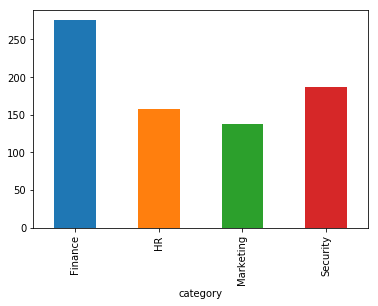

In [13]:
df.groupby('category').text.count().plot.bar(ylim=0)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.text).toarray()
labels = df.category_id
features.shape

(758, 1380)

In [11]:
from sklearn.feature_selection import chi2

N = 3
for category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(category))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'Finance':
  . Most correlated unigrams:
       . shall
       . commissioner
       . bank
  . Most correlated bigrams:
       . bank shall
       . trust company
       . bank trust
# 'HR':
  . Most correlated unigrams:
       . leave
       . employees
       . employee
  . Most correlated bigrams:
       . hours worked
       . exempt employees
       . non exempt
# 'Marketing':
  . Most correlated unigrams:
       . retail
       . communications
       . communication
  . Most correlated bigrams:
       . retail communication
       . investment company
       . retail communications
# 'Purchasing':
  . Most correlated unigrams:
       . processing
       . data
       . controller
  . Most correlated bigrams:
       . controller shall
       . data subject
       . personal data


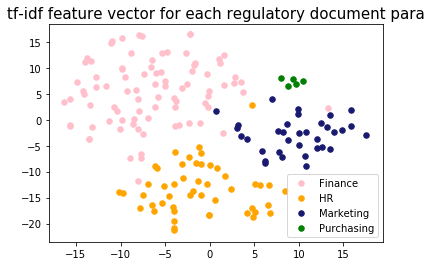

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices])
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
plt.title("tf-idf feature vector for each regulatory document para",
          fontdict=dict(fontsize=15))
plt.legend()

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

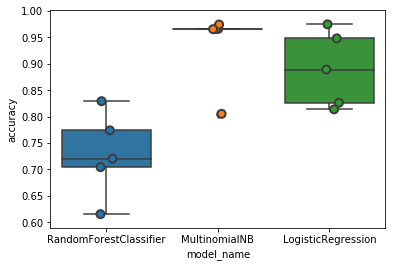

In [14]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

In [15]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.890144
MultinomialNB             0.935168
RandomForestClassifier    0.728609
Name: accuracy, dtype: float64

In [16]:
from sklearn.model_selection import train_test_split

model = LogisticRegression(random_state=0)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

Text(0.5,1,'Confusion Matrix - Multinomial Naive Bayes')

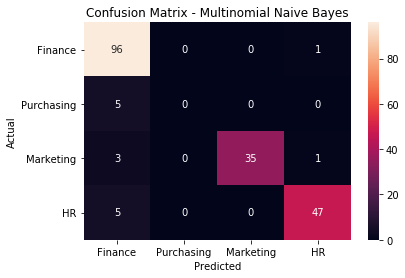

In [17]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Multinomial Naive Bayes')

In [18]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 2:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['category', 'text']])
      print('')

'Purchasing' predicted as 'Finance' : 5 examples.


,category,text
12,Purchasing,"In the case of a personal data breach, the con..."
31,Purchasing,The controller shall implement appropriate tec...
14,Purchasing,Where a type of processing in particular using...
15,Purchasing,1The supervisory authority shall establish and...
10,Purchasing,The data subject shall have the right to recei...



'Marketing' predicted as 'Finance' : 3 examples.


,category,text
21,Marketing,It is second nature for us to handle sensitive...
118,Marketing,(A) that the associated person has a financial...
18,Marketing,Consumer protection laws allow customers wrong...



'HR' predicted as 'Finance' : 5 examples.


,category,text
494,HR,Notify Centricity Solutions of any accidents o...
503,HR,"Harassment is any verbal, physical or visual c..."
455,HR,Willful violations may result in criminal pros...
531,HR,Reference Checks\nInformation should not be pr...
504,HR,Sexual harassment is any unwelcome sexual adva...


In [19]:
model.fit(features, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [20]:
from sklearn.feature_selection import chi2

N = 5
for category, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(category))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Finance':
  . Top unigrams:
       . bank
       . commissioner
       . shall
       . office
       . section
  . Top bigrams:
       . bank shall
       . bank trust
       . trust company
       . branch office
       . pursuant section
# 'HR':
  . Top unigrams:
       . employee
       . employees
       . employer
       . work
       . employers
  . Top bigrams:
       . non exempt
       . labor code
       . sexual harassment
       . hours worked
       . exempt employees
# 'Marketing':
  . Top unigrams:
       . communication
       . member
       . investment
       . communications
       . retail
  . Top bigrams:
       . investment company
       . retail communications
       . products services
       . retail communication
       . investment companies
# 'Purchasing':
  . Top unigrams:
       . data
       . controller
       . personal
       . processing
       . supervisory
  . Top bigrams:
       . personal data
       . data subject
       . controller shall


In [21]:
df[df.text.str.lower().str.contains('business')].category.value_counts()

Finance      57
Marketing    20
HR            5
Name: category, dtype: int64

In [22]:
texts = ["Establishing rules, procedures, and any exceptions necessary to ensure that the notices and information that businesses are required to provide pursuant to this title are provided in a manner that may be easily understood by the average consumer, are accessible to consumers with disabilities, and are available in the language primarily used to interact with the consumer, including establishing rules and guidelines regarding financial incentive offerings, within one year of passage of this title and as needed thereafter.","The development and use of a recognizable and uniform opt-out logo or button by all businesses to promote consumer awareness of the opportunity to opt out of the sale of personal information."]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"Establishing rules, procedures, and any exceptions necessary to ensure that the notices and information that businesses are required to provide pursuant to this title are provided in a manner that may be easily understood by the average consumer, are accessible to consumers with disabilities, and are available in the language primarily used to interact with the consumer, including establishing rules and guidelines regarding financial incentive offerings, within one year of passage of this title and as needed thereafter."
  - Predicted as: 'Marketing'

"The development and use of a recognizable and uniform opt-out logo or button by all businesses to promote consumer awareness of the opportunity to opt out of the sale of personal information."
  - Predicted as: 'Finance'

